In [51]:
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt

from evolution.candidate import Candidate
from evolution.evaluation.evaluator import Evaluator

In [61]:
results_dir = Path("results/actions/dynamic")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes)

63
100 ['CO2 Gross emissions', 'Total cost of energy']


In [53]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

evaluator = Evaluator("experiments/temp", context, actions, outcomes)

make: `enroads' is up to date.


In [54]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,CO2 Gross emissions,Total cost of energy
0,99_80,"['98_80', '98_15']",1,inf,-4.67164,-6.51048
1,99_53,"['98_68', '98_9']",1,inf,-4.73991,-6.22318
2,99_9,"['98_87', '98_71']",1,0.000167,-4.71388,-6.23352
3,99_20,"['97_23', '97_23']",1,0.000130,-4.68081,-6.40396
4,99_37,"['98_33', '98_71']",1,0.000074,-4.68846,-6.28185
5,99_22,"['97_49', '98_26']",1,0.000051,-4.73076,-6.23346
6,99_68,"['98_83', '98_87']",1,0.000044,-4.70403,-6.24914
7,99_81,"['98_9', '98_17']",1,0.000029,-4.68107,-6.33595


In [55]:
baseline_actions = {}
baseline_df = evaluator.evaluate_actions(baseline_actions)
print(baseline_df[outcomes].iloc[-1])

CO2 Gross emissions     51.8455
Total cost of energy    14.0347
Name: 110, dtype: float64


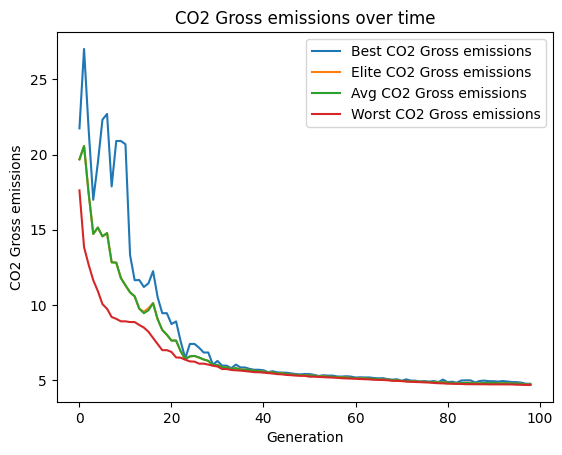

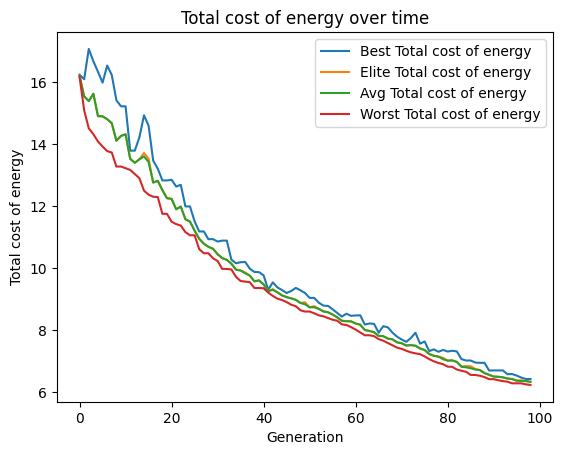

In [56]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto[outcome] * -1
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.nlargest(n_elites).mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Best {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Worst {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_52601/1340272597.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


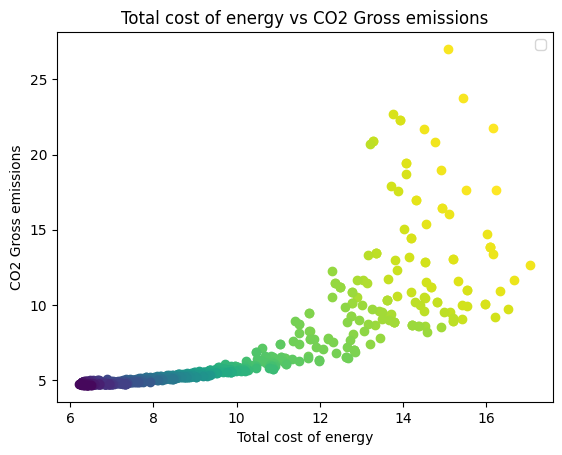

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_52601/1340272597.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


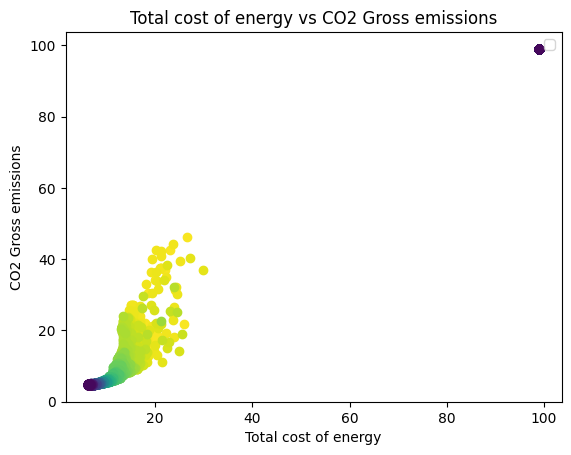

In [57]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):
    colors = plt.cm.viridis_r([i / (len(gens)+1) for i in range(len(gens)+1)])
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        plt.scatter(-1 * gen_df[outcome1], -1 * gen_df[outcome2], color=colors[gens.index(gen)])

    # plt.scatter(baseline_df[outcome1].iloc[-1], baseline_df[outcome2].iloc[-1], color="black", label="Baseline")
    plt.legend()
    plt.title(f"{outcome1} vs {outcome2}")
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcomes[1], outcomes[0], range(gens+1))
plot_two_objective(outcomes[1], outcomes[0], range(gens+1), pareto=False)

In [58]:
def get_candidate_actions(candidate: Candidate, torch_context):
    cand_actions = dict(zip(actions, candidate.prescribe(torch_context)))
    return cand_actions

def get_candidate_from_id(results_dir: Path, cand_id: str):
    cand_path = results_dir / cand_id.split("_")[0] / f"{cand_id}.pt"
    return Candidate.from_seed(cand_path, model_params, actions, outcomes)

In [62]:
cand = get_candidate_from_id(results_dir, "99_80")
cand_actions = get_candidate_actions(cand, evaluator.torch_context)
cand_outcomes = evaluator.evaluate_candidate(cand)
print(cand_actions)
print(cand.metrics)

{'_source_subsidy_delivered_coal_tce': 31.156017303466797, '_source_subsidy_start_time_delivered_coal': 2049.50244140625, '_source_subsidy_stop_time_delivered_coal': 2072.88525390625, '_no_new_coal': 44.46435546875, '_year_of_no_new_capacity_coal': 2095.442626953125, '_utilization_adjustment_factor_delivered_coal': 49.86665344238281, '_utilization_policy_start_time_delivered_coal': 2065.403076171875, '_utilization_policy_stop_time_delivered_coal': 2080.39697265625, '_target_accelerated_retirement_rate_electric_coal': 3.4552106857299805, '_source_subsidy_delivered_oil_boe': 31.541595458984375, '_source_subsidy_start_time_delivered_oil': 2058.05419921875, '_source_subsidy_stop_time_delivered_oil': 2083.09765625, '_no_new_oil': 85.31696319580078, '_year_of_no_new_capacity_oil': 2026.5301513671875, '_utilization_adjustment_factor_delivered_oil': 24.49080467224121, '_utilization_policy_start_time_delivered_oil': 2066.06201171875, '_utilization_policy_stop_time_delivered_oil': 2073.938720703

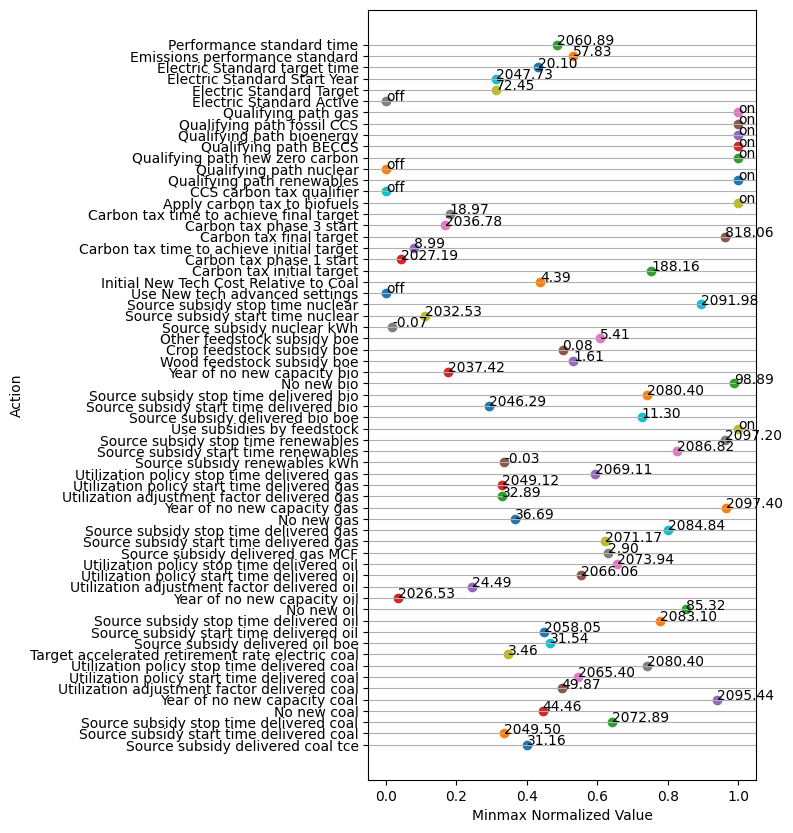

In [94]:
input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
i = 0
fig, ax = plt.subplots(figsize=(5, 10))
for act, val in cand_actions.items():
    row = input_specs[input_specs["varId"] == act]
    if row["kind"].iloc[0] == "slider":
        min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
        max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
        assert val >= min_val and val <= max_val
        normalized_y = (val - min_val) / (max_val - min_val)
        # ax.scatter([i, i, i], [0, normalized_y, 1])
        ax.scatter([normalized_y], [i])
        ax.annotate(f"{val:.2f}", (normalized_y, i))
    else:
        assert val == 0 or val == 1
        ax.scatter([val], [i])
        ax.annotate("on" if val == 1 else "off", (val, i))
    
    i += 1

ax.set_yticks(range(len(cand_actions)))
labels = [input_specs[input_specs["varId"] == act]["varName"].iloc[0] for act in cand_actions.keys()]
ax.set_yticklabels(labels)
plt.ylabel("Action")
plt.xlabel("Minmax Normalized Value")
plt.grid(axis="y")
plt.show()

In [77]:
for i in range(9):
    act = actions[i]
    print(act, cand_actions[act])
print()
for i in range(9, 17):
    act = actions[i]
    print(act, cand_actions[act])
print()
for i in range(17, 25):
    act = actions[i]
    print(act, cand_actions[act])
print()
for i in range(25, )

_source_subsidy_delivered_coal_tce 31.156017303466797
_source_subsidy_start_time_delivered_coal 2049.50244140625
_source_subsidy_stop_time_delivered_coal 2072.88525390625
_no_new_coal 44.46435546875
_year_of_no_new_capacity_coal 2095.442626953125
_utilization_adjustment_factor_delivered_coal 49.86665344238281
_utilization_policy_start_time_delivered_coal 2065.403076171875
_utilization_policy_stop_time_delivered_coal 2080.39697265625
_target_accelerated_retirement_rate_electric_coal 3.4552106857299805

_source_subsidy_delivered_oil_boe 31.541595458984375
_source_subsidy_start_time_delivered_oil 2058.05419921875
_source_subsidy_stop_time_delivered_oil 2083.09765625
_no_new_oil 85.31696319580078
_year_of_no_new_capacity_oil 2026.5301513671875
_utilization_adjustment_factor_delivered_oil 24.49080467224121
_utilization_policy_start_time_delivered_oil 2066.06201171875
_utilization_policy_stop_time_delivered_oil 2073.938720703125

_source_subsidy_delivered_gas_mcf 2.8985183238983154
_source_s

In [63]:
best = {'_source_subsidy_delivered_coal_tce': 100, '_source_subsidy_start_time_delivered_coal': 2024, '_source_subsidy_stop_time_delivered_coal': 2100, '_no_new_coal': 100, '_year_of_no_new_capacity_coal': 2024, '_utilization_adjustment_factor_delivered_coal': 100, '_utilization_policy_start_time_delivered_coal': 2024, '_utilization_policy_stop_time_delivered_coal': 2100, '_target_accelerated_retirement_rate_electric_coal': 9}
outcomes_df = evaluator.evaluate_actions(best)
print(outcomes_df[outcomes].iloc[-1])

CO2 Gross emissions     48.1733
Total cost of energy    12.5445
Name: 110, dtype: float64
